In [3]:
import os
import librosa
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder
import whisper

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

import sounddevice as sd
from scipy.io.wavfile import write
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

In [4]:
data_dir = "AudioWAV/"
emotion_map = {
    "ANG": "Anger",
    "DIS": "Disgust",
    "FEA": "Fear",
    "HAP": "Happy",
    "NEU": "Neutral",
    "SAD": "Sad"
}

file_paths = []
labels = []

for fname in os.listdir(data_dir):
    if fname.endswith(".wav"):
        parts = fname.split("_")
        emotion_code = parts[2]
        if emotion_code in emotion_map:
            file_paths.append(os.path.join(data_dir, fname))
            labels.append(emotion_map[emotion_code])

In [5]:
def extract_mel_spectrogram(file_path, n_mels=256, max_len=256):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel = librosa.power_to_db(mel_spec)

    # Pad or truncate to fixed length
    if log_mel.shape[1] < max_len:
        pad_width = max_len - log_mel.shape[1]
        log_mel = np.pad(log_mel, pad_width=((0,0), (0, pad_width)), mode='constant')
    else:
        log_mel = log_mel[:, :max_len]

    return log_mel

In [6]:
X = []
for path in file_paths:
    spec = extract_mel_spectrogram(path)
    X.append(spec)

X = np.array(X)
X = X[..., np.newaxis]  # (samples, 128, 128, 1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Normalize
X = X / np.max(X)

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
with open("label_encoder-2.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=6,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)
model.save("cnn_emotion_model-2.h5")



/Users/shrek/Desktop/courses/semester 8/nlp/nlp-cs-4420/project/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 492ms/step - accuracy: 0.3178 - loss: 1.6246 - val_accuracy: 0.4597 - val_loss: 1.3669 - learning_rate: 0.0010
Epoch 2/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 85s 504ms/step - accuracy: 0.4485 - loss: 1.3703 - val_accuracy: 0.4821 - val_loss: 1.3173 - learning_rate: 0.0010
Epoch 3/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 91s 544ms/step - accuracy: 0.4929 - loss: 1.2795 - val_accuracy: 0.5373 - val_loss: 1.2279 - learning_rate: 0.0010
Epoch 4/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 587ms/step - accuracy: 0.5600 - loss: 1.1464 - val_accuracy: 0.5485 - val_loss: 1.2044 - learning_rate: 0.0010
Epoch 5/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 98s 584ms/step - accuracy: 0.6051 - loss: 1.0458 - val_accuracy: 0.5530 - val_loss: 1.2120 - learning_rate: 0.0010
Epoch 6/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 603ms/step - accuracy: 0.6367 - loss: 0.9484 - val_accuracy: 0.5604 - val_loss: 1.2244 - learning_rate: 0.0010


In [ ]:
#testing imports
import os
import librosa
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder
import whisper

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

import sounddevice as sd
from scipy.io.wavfile import write
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

In [8]:
model = load_model("cnn_emotion_model-2.h5")
with open("label_encoder-2.pkl", "rb") as f:
    label_encoder = pickle.load(f)

def predict_emotion_from_audio(audio_path):
    # Load audio
    y, sr = librosa.load(audio_path, sr=22050)
    
    # Extract Mel spectrogram with 256 Mel bands
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Resize time dimension to 256
    if mel_db.shape[1] < 256:
        pad_width = 256 - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :256]

    # Reshape for CNN input
    mel_db = mel_db.reshape(1, 256, 256, 1)
    mel_db = mel_db / np.max(mel_db)

    # Predict
    prediction = model.predict(mel_db)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]


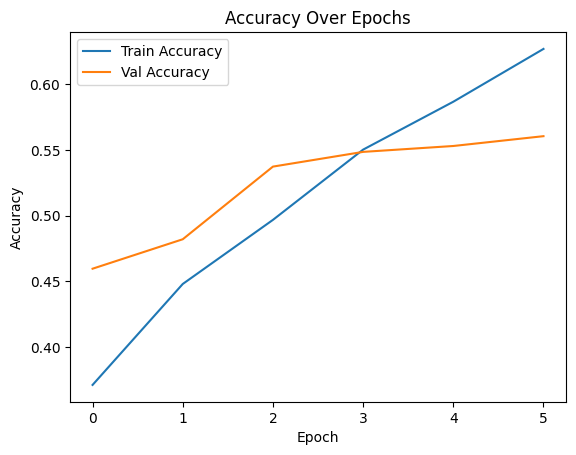

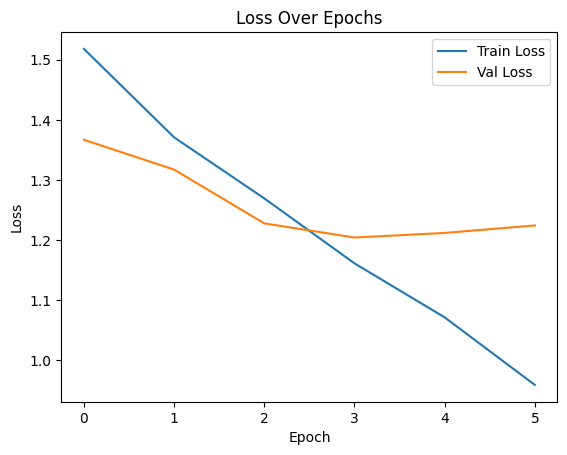

In [9]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Load model and tokenizer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# GoEmotions labels used by the model
goemotions_labels = [
    'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'
]

# Map GoEmotions labels to CREMA-D's 6 classes
go_to_crema_map = {
    "anger": "Anger",
    "annoyance": "Anger",
    "disgust": "Disgust",
    "fear": "Fear",
    "nervousness": "Fear",
    "joy": "Happy",
    "excitement": "Happy",
    "sadness": "Sad",
    "grief": "Sad",
    "neutral": "Neutral"
}

from collections import Counter

def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)[0]

    # Get top 3 GoEmotions
    top_indices = torch.topk(probs, 3).indices.tolist()
    top_go_labels = [goemotions_labels[i] for i in top_indices]

    # Map to CREMA-D categories and vote
    mapped = [go_to_crema_map.get(label) for label in top_go_labels if label in go_to_crema_map]
    if mapped:
        final = Counter(mapped).most_common(1)[0][0]
    else:
        final = "Unknown"

    return final, {label: probs[i].item() for i, label in enumerate(goemotions_labels)}


text = "I am so happy to see you!"
emotion, scores = predict_emotion(text)
print(f"Predicted CREMA-D Emotion: {emotion}")

Predicted CREMA-D Emotion: Happy


In [11]:
# Load Whisper model
import whisper
whisper_model = whisper.load_model("base")

# CREMA-D labels
crema_labels = ["Anger", "Disgust", "Fear", "Happy", "Neutral", "Sad"]

def predict_text_probs(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)[0]
    
    crema_probs = {label: 0.0 for label in crema_labels}
    for i, go_label in enumerate(goemotions_labels):
        mapped = go_to_crema_map.get(go_label)
        if mapped:
            crema_probs[mapped] += probs[i].item()

    return np.array([crema_probs[label] for label in crema_labels]).reshape(1, -1)

def predict_audio_probs(audio_path):
    y_audio, sr = librosa.load(audio_path, sr=22050)
    mel = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=256)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    # Pad or truncate the time dimension to 256
    if mel_db.shape[1] < 256:
        pad_width = 256 - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :256]
        
    mel_db = mel_db.reshape(1, 256, 256, 1)
    
    # Normalize, handling potential division by zero
    max_val = np.max(mel_db)
    if max_val > 0:
        mel_db = mel_db / max_val
    else:
        # If max_val is 0 (e.g., silence), mel_db is already effectively zeros or should be.
        # This prevents NaN/inf values. The model will receive zeros.
        mel_db = np.zeros_like(mel_db) 
        
    cnn_model = load_model("cnn_emotion_model-2.h5")
    return cnn_model.predict(mel_db)

def full_multimodal_emotion_pipeline(audio_path, alpha=0.5, verbose=True):
    # Transcribe using Whisper
    transcription_result = whisper_model.transcribe(audio_path)
    text = transcription_result["text"].strip()

    # Predict from audio
    audio_probs = predict_audio_probs(audio_path)

    # Predict from text
    text_probs = predict_text_probs(text)

    # Late fusion
    final_probs = alpha * audio_probs + (1 - alpha) * text_probs
    final_label = crema_labels[np.argmax(final_probs)]

    if verbose:
        print(f"Transcription: {text}")
        print(f"Predicted Emotion: {final_label}")

    return final_label, final_probs, text


In [12]:
# Replace this with the path to your .wav file
test_audio_path = "test.mp3"

# Run the full pipeline
final_emotion, fusion_probs, transcription = full_multimodal_emotion_pipeline(test_audio_path)

print("\n--- Final Results ---")
print(f"Transcription      : {transcription}")
print(f"Predicted Emotion  : {final_emotion}")
#print(f"Emotion Probabilities (CREMA-D order): {fusion_probs}")

/Users/shrek/Desktop/courses/semester 8/nlp/nlp-cs-4420/project/.venv/lib/python3.9/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Transcription: Hurry! Shut up! What? I'm sorry, please don't speak to me like that. I am simply saying to you... Will you shut up? Hey! Shut the hell up! Shut up! Shut up! Guys, shut up! Please shut up! Shut up! Shut up! Shut up! Shut up! Shut up! Shut up! Shut up! Shut up!
Predicted Emotion: Anger

--- Final Results ---
Transcription      : Hurry! Shut up! What? I'm sorry, please don't speak to me like that. I am simply saying to you... Will you shut up? Hey! Shut the hell up! Shut up! Shut up! Guys, shut up! Please shut up! Shut up! Shut up! Shut up! Shut up! Shut up! Shut up! Shut up! Shut up!
Predicted Emotion  : Anger


In [13]:
# import sounddevice as sd
# from scipy.io.wavfile import write
# import os
# import ipywidgets as widgets
# from IPython.display import display, clear_output

record_seconds = 5
fs = 22050  # Sample rate

record_button = widgets.Button(description="🎙️ Record Audio")
output_area = widgets.Output()

def record_audio(b):
    output_area.clear_output()
    with output_area:
        print("Recording...")
        recording = sd.rec(int(record_seconds * fs), samplerate=fs, channels=1)
        sd.wait()
        wav_path = "recorded_audio.wav"
        write(wav_path, fs, recording)
        print("Recording saved.")

        # Run prediction pipeline
        print("Running emotion recognition...")
        try:
            final_emotion, fusion_probs, transcription = full_multimodal_emotion_pipeline(wav_path)
            print("\n--- Results ---")
            print(f"Transcription      : {transcription}")
            print(f"Predicted Emotion  : {final_emotion}")
            #rint(f"Probabilities (CREMA-D order): {fusion_probs}")
        except Exception as e:
            print(f"Error during prediction: {e}")

record_button.on_click(record_audio)
display(record_button, output_area)

Button(description='🎙️ Record Audio', style=ButtonStyle())

Output()